# Diabetes Classification Model

## Summary

We attempt to develop a logistic regression model to predict whether a patient has diabetes or not using the Diabetes Health Indicators dataset sourced from the UCI machine learning repository (CDC, 2023). We use Random Over-Sampling Examples (ROSE) to balance the data and a tuned Least Absolute Shrinkage and Selection Operator (LASSO) regression model to classify patients who are at high risk of developing diabetes, using 12 out of the 21 risk factors provided in the dataset. Recall was used to measure the classifier's performance, as the consequences of false negatives for this task would be more severe than that of false positives. The area under the receiver operating characteristic curve (ROC AUC) was also chosen to evaluate the model's effectiveness in distinguishing between the two classes.

## Introduction

Diabetes is a chronic condition that occurs when blood sugar levels remain elevated due to excess buildup in the bloodstream. Diabetes is linked to a variety of complications, including retinopathy, cardiovascular disease, stroke, and reduced resistance to infections (Papatheodorou, Banach, Bekiari, Rizzo, Edmonds, 2018). In 2021, diabetes-related conditions resulted in over 2 million deaths worldwide (World Health Organization, 2024). Accurate diagnosis in the early stages is crucial as interventions can be administered to prevent the progression of diabetes (Mayo Foundation for Medical Education and Research, 2024). 

This project aims to develop a classification model to predict diabetes status based on various health indicators. By using data preprocessing strategies, we seek to improve the accuracy of diabetes detection using publicly available health datasets.

The dataset used in this project is sourced from the [CDC Diabetes Health Indicators dataset sourced from the UCI machine learning repository](https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators) (CDC, 2023), which contains various demographic and lifestyle-related features that may influence the likelihood of diabetes. The primary objective is to classify individuals into diabetic (1) or non-diabetic (0) categories using predictive modelling.

## Methods & Results

<!-- *describe in written english the methods you used to perform your analysis from beginning to end that narrates the code the does the analysis.* -->
The project follows a structured approach to data preparation, exploration, and classification modelling.
- Firstly, The dataset is obtained from an external source and loaded into R. Then, the raw dataset is inspected for completeness and correctness. Checking for missing values and unique values in each feature. Converting categorical variables (such as age, smoking status, and blood pressure) into factor types to facilitate analysis.
- Moreover, the dataset is highly imbalanced, with more non-diabetic cases than diabetic ones. To address this, the ROSE (Random Over-Sampling Examples) technique is applied to generate synthetic data points and balance the dataset.
- Various visualizations (bar plots, box plots, and scatter plots) are generated to explore the relationships between health indicators and diabetes status. Trends in factors such as BMI, high blood pressure, cholesterol levels, and physical activity are examined. The dataset is split into 75% training data and 25% testing data to build and evaluate machine learning models.
- [INSERT TEXT HERE]

### (1) Loading Data from Original Source On The Web
The packages used in this document are `reticulate`, `tidyverse`, `tidymodels`, `glmnet`, `patchwork`, `ROSE` and `purrr`. The dataset of interest can be acquired from the source by running `dataset_download.py` through `py_run_file()`, which writes the result into `cdc_diabetes_health_indicators.csv`; the latter is then read into the variable `raw_diabetes_df`.

In [1]:
install.packages("glmnet")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
library(reticulate) # Run python code in R
library(tidyverse) # Data wrangling
library(tidymodels) # Machine learning
library(glmnet) # Fit generalized linear models by penalty
library(patchwork) # Combine plots
library(ROSE) # Random Over-Sampling Examples
library(purrr) # Functional programming

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.2.0 ──

✔ broom        1.0.7     ✔ rsample      1.2.1
✔ dials        1.4.0     ✔ tune         1.2.1
✔ infer        1.0.7     ✔ workflows    1.2.0
✔ modeldata    1.4.0     ✔ workflowsets 1.1.0
✔ parsnip      1.3.0     ✔ yardstick    1.3.2
✔ recipes      1.1.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [3]:
# OPTIONAL; only run if cdc_diabetes_health_indicators.csv does not exist
py_run_file("/home/jovyan/work/src/dataset_download.py")

In [4]:
raw_diabetes_df <- read_csv("/home/jovyan/work/data/raw/cdc_diabetes_health_indicators.csv", show_col_types = FALSE)
head(raw_diabetes_df, n = 3)

HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,⋯,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,Diabetes_binary
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1,40,1,0,0,0,0,1,⋯,0,5,18,15,1,0,9,4,3,0
0,0,0,25,1,0,0,1,0,0,⋯,1,3,0,0,0,0,7,6,1,0
1,1,1,28,0,0,0,0,1,0,⋯,1,5,30,30,1,0,9,4,8,0


### (2) Preprocessing: Wrangle, Clean, and Balance Data From Original Format
The variables are all checked for the following attributes:
- `NA_Count`: Number of "NA" values within each variable; if they existed, they would need to be replaced or removed.
- `Distinct_Count`: Distinct counts for each variable; primarily to check which variables are numerical, categorical or binary.
- `Current_Data_Type`: Current data type for each variable; primarily to ensure that they are in the appropriate format we require, as the data type may be lost during `read_csv()`.

Given the initial check, the following observations can be made: 
- None of the columns have `NA` values.
- `BMI` is the only numerical variable, with the rest being categorical or binary.
- All variables are treated as `double`, and thus every variable except for `BMI` will need to be converted to the factor data type.

We seek to balance the dataset we will use for our machine learning model to mitigate bias towards the majority class, improve the model's ability generalise to unseen data, and make the training of the model more efficient. Our count of each category of `Diabetes_binary` in the `raw_diabetes_df` dataset has about 86% of the people provided to not have diabetes; `raw_diabetes_df` is heavily imbalanced. The function `ROSE()` is used to balance the dataset to form `balanced_raw_diabetes_df`, such that the size of `balanced_raw_diabetes_df` is equal to that of `raw_diabetes_df`, by undersampling the majority class and oversampling the minority class. `balanced_raw_diabetes_df` will be written into the file `data/processed/`, and will be split into the training and testing sets `diabetes_train` and `diabetes_test` respectively in preparation for machine learning.

In [5]:
# (1) Check NA values, the distinct Count of each variable (to see which ones are categorical/binary), and the current data type

checking_raw_matrix <- rbind(
  NA_Count = sapply(raw_diabetes_df, function(x) sum(is.na(x))),
  Distinct_Count = sapply(raw_diabetes_df, function(x) n_distinct(x)),
  Current_Data_Type = sapply(raw_diabetes_df, typeof)
)

checking_raw_df <- as.data.frame(t(checking_raw_matrix))

checking_raw_df
# --------------------------------------
# observations
# (1) no NA values
# (2) all var except BMI are numerical. Rest are categorical/binary. See metadata for detail
# (3) Currently, all are double. 

,NA_Count,Distinct_Count,Current_Data_Type
,<chr>,<chr>,<chr>
HighBP,0,2,double
HighChol,0,2,double
CholCheck,0,2,double
BMI,0,84,double
Smoker,0,2,double
Stroke,0,2,double
HeartDiseaseorAttack,0,2,double
PhysActivity,0,2,double
Fruits,0,2,double


In [6]:
# (2) converting categorical/binary variables into factors

raw_diabetes_df <- raw_diabetes_df %>%
  mutate(across(!BMI, ~ factor(.)))

In [7]:
# (3) check how unbalance is the dataset + balance the data

# it's pretty unbalanced
target_result <- raw_diabetes_df %>%
  group_by(Diabetes_binary) %>%
  summarise(Count = n(), Proportion = n() / nrow(raw_diabetes_df)) %>%
  ungroup()

# ----------------------------------------
# use ROSE to balance data by oversampling

set.seed(6)

balanced_raw_diabetes_df <- ROSE(Diabetes_binary ~ ., data = raw_diabetes_df, seed = 123)$data

balanced_target_result <- balanced_raw_diabetes_df %>%
  group_by(Diabetes_binary) %>%
  summarise(Count = n(), Proportion = n() / nrow(balanced_raw_diabetes_df)) %>%
  ungroup()

# -----------------------------------------
balanced_raw_comparision_df <- data.frame(
  Class = target_result$Diabetes_binary,
  Original_Count = target_result$Count,
  Original_Proportion = target_result$Proportion,
  Balanced_Count = balanced_target_result$Count,
  Balanced_Proportion = balanced_target_result$Proportion
)

balanced_raw_comparision_df

Class,Original_Count,Original_Proportion,Balanced_Count,Balanced_Proportion
<fct>,<int>,<dbl>,<int>,<dbl>
0,218334,0.860667,126884,0.5001734
1,35346,0.139333,126796,0.4998266


In [8]:
# (4) Write out balanced df into data/processed/ so we don't have to run all the step above each time
balanced_raw_diabetes_df %>% write_csv("/home/jovyan/work/data/processed/balanced_cdc_diabetes_health_indicators.csv")

In [9]:
# Then read it out again so we dont have to run the steps above
balanced_raw_diabetes_df <- read_csv("/home/jovyan/work/data/processed/balanced_cdc_diabetes_health_indicators.csv", show_col_types = FALSE) %>%
  mutate(across(!BMI, ~ factor(.)))

In [10]:
# (5) Split data into train + test for ML
set.seed(6)

diabetes_split <- initial_split(balanced_raw_diabetes_df, prop = 0.75, strata = Diabetes_binary)
diabetes_train <- training(diabetes_split)
diabetes_test <- testing(diabetes_split)

### (3) EDA - Summary Statistics

In [11]:
# <chi-square-test-here>

### (4) EDA - Visualization
The large number of variables could lead to a risk of overfitting and difficulty in interpretation, and thus the visualisations below are created to decide on which variables to select. Bar plots indicating the proportions of `Diabetes_binary` for each categorical variable are displayed, along with a density plot for `BMI`. 

Of the given variables, `HighBP`, `HighChol`, `CholCheck`, `Stroke`, `HeartDiseaseorAttack`, `HvyAlcoholConsump`, `DiffWalk`, `Age`, `Education`, `Income`, `GenHlth` provide significant differences in distribution among their categories. As such, they will be used for our model.

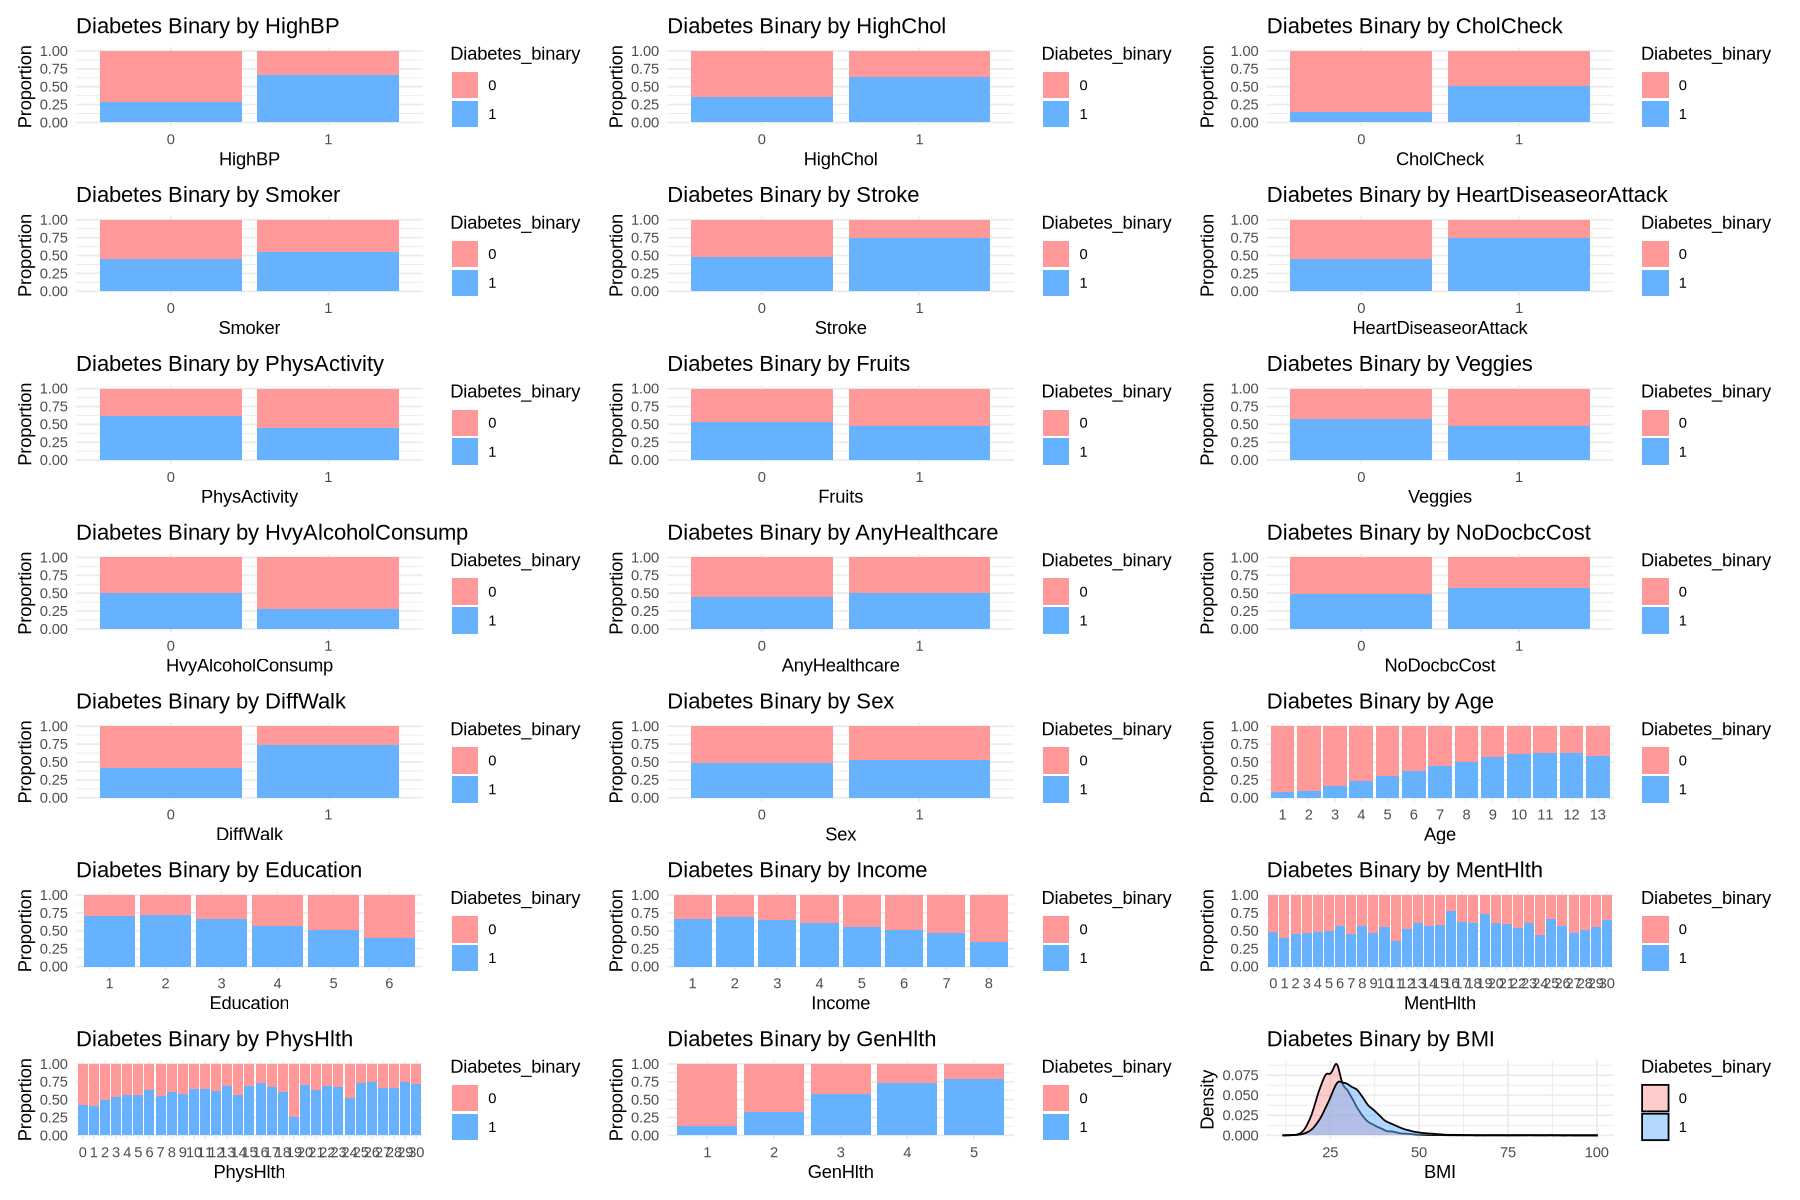

In [12]:
options(repr.plot.width = 15, repr.plot.height = 10, warn = -1)

# binary
binary_vars <- c("HighBP", "HighChol", "CholCheck", "Smoker", "Stroke", 
                      "HeartDiseaseorAttack", "PhysActivity", "Fruits", "Veggies", 
                      "HvyAlcoholConsump", "AnyHealthcare", "NoDocbcCost", 
                      "DiffWalk", "Sex", "Age", "Education", "Income", "MentHlth", "PhysHlth", "GenHlth")

# not binary
nonbinary_var <- c("BMI")

# --------------------------------------------------
# inits
bar_plots <- list()
density_plots <- list()

# --------------------------------------------------
# Bar plots
for (var in binary_vars) {
  p <- ggplot(diabetes_train, aes(x = !!sym(var), fill = as.factor(Diabetes_binary))) +
    geom_bar(position = "fill") + 
    scale_fill_manual(values = c("#FF9999", "#66B2FF")) + 
    labs(title = paste("Diabetes Binary by", var),
         x = var,
         y = "Proportion",
         fill = "Diabetes_binary") +
    theme_minimal()
  bar_plots[[var]] <- p
}


# --------------------------------------------------
# Density plots

for (var in nonbinary_var) {
  p <- ggplot(diabetes_train, aes(x = !!sym(var), fill = as.factor(Diabetes_binary))) +
    geom_density(alpha = 0.5) +
    scale_fill_manual(values = c("#FF9999", "#66B2FF")) + 
    labs(title = paste("Diabetes Binary by", var),
         x = var,
         y = "Density",
         fill = "Diabetes_binary") +
    theme_minimal()
  density_plots[[var]] <- p
}

# ----------------------------------------------------------------------------------------------
combined_plots <- wrap_plots(c(bar_plots, density_plots), ncol = 3, nrow = 7)
print(combined_plots, width = 15, height = 8)

### (5) Classification Analysis
The large quantity of binary variables in the model, along with the task being for classification, means that a logistic regression model `lr_mod` will be required. The v-fold cross validation split `vfold_cv()` is created in preparation for cross-validation of the dataset, to provide a more effective estimate of the model performance. `lr_recipe` is created to apply one-hot encoding to the binary variables, and normalisation to all numerical variables.

`lambda_grid` is created as a grid of hyperparameters for tuning with the cross-validation set with penalty terms, while `tune_grid()` is used for hyperparameter tuning, specifically tuned for higher recall, as the consequences of false negatives for this task would be more severe. The metric that maximises recall is selected for the finalised workflow `lasso_tuned_wflow`.

In [13]:
# --------------------------------------------------
# select only var we want first

diabetes_train_filtered <- diabetes_train %>%
  select(Diabetes_binary, HighBP, HighChol, CholCheck, Stroke, HeartDiseaseorAttack, 
         HvyAlcoholConsump, DiffWalk, Age, Education, Income, GenHlth)

# ---------------------------------------------------
# pipeline for logistic regression 

lr_mod <- logistic_reg(penalty = tune(), mixture = 1) %>% 
    set_engine("glmnet") %>%
    set_mode("classification")

folds <- vfold_cv(diabetes_train_filtered, v=5)

lr_recipe <- recipe(Diabetes_binary ~ ., data = diabetes_train_filtered) %>%
  step_dummy(all_nominal_predictors(), -all_ordered()) %>% 
  step_normalize(all_predictors())

lr_workflow <- workflow() %>%
  add_recipe(lr_recipe)

In [14]:
# tuning with cv set for penalty

lambda_grid <- grid_max_entropy(penalty(), size = 10)

lasso_grid <- tune_grid(lr_workflow %>% add_model(lr_mod),
                                               resamples = folds,
                                               grid = lambda_grid,
                                               metrics = metric_set(recall))

In [15]:
# chose the metric with highest recall

highest_auc <- lasso_grid %>% select_best(metric = "recall")

lasso_tuned_wflow <- finalize_workflow(lr_workflow %>% 
                     add_model(lr_mod),highest_auc) %>%
                     fit(data = diabetes_train_filtered)

### (6) Result of Analysis - Visualization
The results of our LASSO regression predictions include `lasso_preds`, which provides the predictions for each row, `lasso_probs`, which provides the probability of each classification for each row, and `lasso_metrics`, which displays the following metrics:
- `sens`: Sensitivity; true positive rate
- `spec`: Specificity; true negative rate
- `ppv`: Positive predictive value; precision
- `npv`: Negative predictive value
- `accuracy`: Accuracy for all predictions
- `recall`: Recall; true positive rate
- `f_meas`: F-measure; harmonic mean of precision and recall
- `roc_auc_value`: ROC AUC value; measure of the model's effectiveness in distinguishing between classes.

The values of particular interest are the `recall` score of 0.7537462 (7 s.f.) and the `roc_auc_value` of 0.8047426 (7 s.f.).

In [16]:
# apply on test set

lasso_preds <- lasso_tuned_wflow %>% predict(diabetes_test)
lasso_probs <- lasso_tuned_wflow %>% predict(diabetes_test, type="prob")
lasso_modelOutputs <- cbind(diabetes_test, lasso_preds, lasso_probs)

classificationMetrics <- metric_set(sens, spec, ppv, npv, accuracy, recall, f_meas)
roc_auc_value <- roc_auc(lasso_modelOutputs, truth = Diabetes_binary, .pred_1, event_level = "second")

lasso_metrics <- rbind(classificationMetrics(lasso_modelOutputs, truth = Diabetes_binary, estimate = .pred_class, event_level = "second"), 
                       roc_auc_value)
lasso_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
sens,binary,0.7537462
spec,binary,0.7063460
ppv,binary,0.7194953
npv,binary,0.7416258
accuracy,binary,0.7300378
recall,binary,0.7537462
f_meas,binary,0.7362226
roc_auc,binary,0.8047426


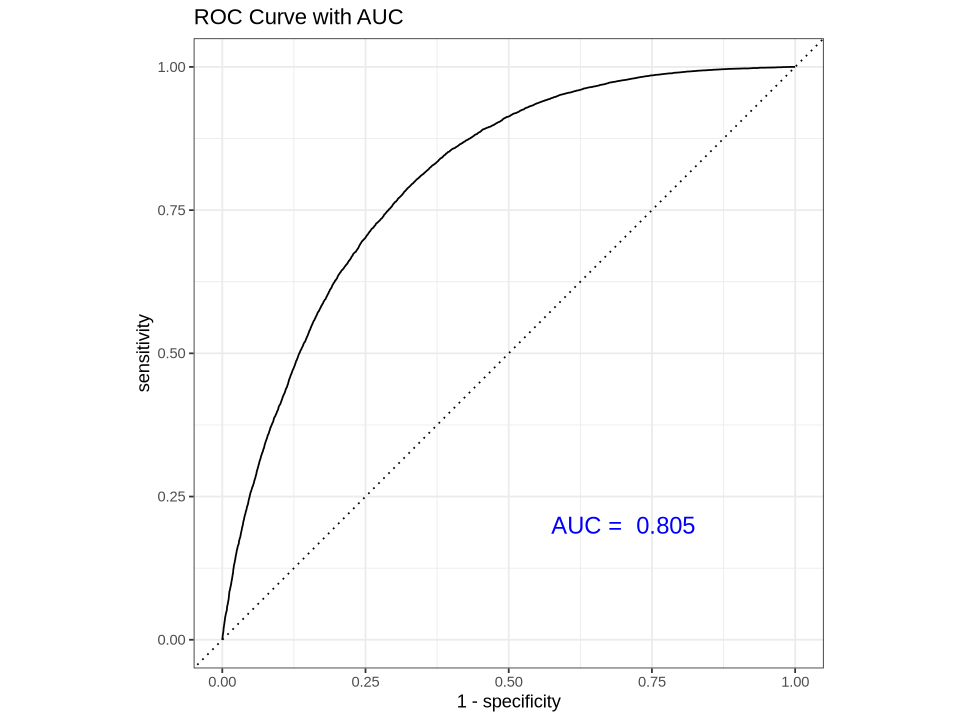

In [17]:
options(repr.plot.width = 8, repr.plot.height = 6)
autoplot(roc_curve(lasso_modelOutputs, Diabetes_binary, .pred_1, event_level = "second")) + 
    ggtitle("ROC Curve with AUC") +
    annotate("text", x = 0.7, y = 0.2, label = paste("AUC = ", round(roc_auc_value$.estimate, 3)), size = 5, color = "blue")

## Discussion

Our model achieved a recall score of 0.7537462 (7 s.f.) on the test set, implying that about 75.37% of all positive instances of diabetes were correctly classified by the LASSO regression model. This suggests that the model is relatively effective at identifying individuals who are at risk of developing diabetes. Additionally, the model achieved an area under the ROC curve of 0.8047426 (7 s.f.) on the test set. Since the AUC is above 0.5, this indicates that the model can discriminate between diabetic and non-diabetic cases better than random guessing.

We expected the model to perform better than random guessing, which it did achieve. Additionally, we aimed to minimize false negatives which is particularly important in healthcare diagnoses where a false negative case can have serious consequences. For example, a false negative would indicate that the model predicts the patient to not develop diabetes even though they do. This may lead to the patient not getting the treatment or care they need, potentially resulting in health complications and even death. Our model was optimized for recall through hyperparameter tuning, with cross-validation used to evaluate model performance during the process. However, despite our results, the model falls short of what is expected in clinical applications. For example, more complex models in the literature which incorporate advanced feature selection techniques (Alhussan et al., 2023) or Generative Adversarial Networks (GANs) (Feng et al., 2023) can achieve recall and AUC scores upwards of 97%. 

Our findings serve as a proof of concept for the feasibility of classification models to predict the risk of diabetes based on publicly available health data. Since our model did relatively well compared to random guessing, this indicates potential correlations between health indicators and the likelihood of developing diabetes. With this information, people might be more aware of their health and lifestyle choices. They may be inclined to work harder to reduce cholesterol levels, manage high blood pressure, keep alcohol consumption under control and maintain a healthy lifestyle. Thus, this may help decrease the global mortality rate from diabetes through early interventions and lifestyle changes. 

Future directions could include how we can improve our classification method to more accurately predict the risk of diabetes in patients. We can explore more rigorous feature selection techniques or implement other machine learning models such as boosted trees to improve our classification performance. In the context of the healthcare system, we can look to integrate classification models into the diagnosis process to help detect diabetes early to improve patient outcomes. 

## References

- CDC. (2023, September 25). UCI Machine Learning Repository CDC diabetes health indicators. CDC diabetes health indicators. https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators
- World Health Organization. (2024, November 14). Diabetes. World Health Organization. https://www.who.int/news-room/fact-sheets/detail/diabetes
- Mayo Foundation for Medical Education and Research. (2024, March 27). Diabetes. Mayo Clinic. https://www.mayoclinic.org/diseases-conditions/diabetes/symptoms-causes/syc-20371444
- Papatheodorou, K., Banach, M., Bekiari, E., Rizzo, M., & Edmonds, M. (2018, March 11). Complications of Diabetes 2017. Wiley Online Library. https://doi.org/10.1155/2018/3086167 
- Alhussan, A. A., Abdelhamid, A. A., Towfek, S. K., Ibrahim, A., Eid, M. M., Khafaga, D. S., & Saraya, M. S. (2023). Classification of diabetes using feature selection and hybrid Al-Biruni Earth radius and dipper throated optimization. *Diagnostics, 13*(12), 2038. https://doi.org/10.3390/diagnostics13122038
- Feng, X., Cai, Y., & Xin, R. (2023). Optimizing diabetes classification with a machine learning-based framework. *BMC Bioinformatics, 24*(1). https://doi.org/10.1186/s12859-023-05467-x